<a href="https://colab.research.google.com/github/RVasconcelosMiguel/ComputerVision/blob/main/CV_Proj2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Body>   
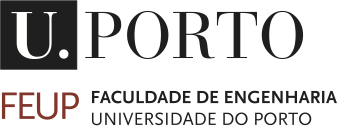   
<h1> <b>Computer Vision 2024/2025 (Assignment 2) </b> </h1>
<p>Master in Electrical and Computer Engineering </p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  

### **Developed by:**
*   Bernardo de Almeida Soeiro - up202008204
*   Rodrigo de Vasconcelos e Miguel - up202008406
*   Tomás Rosa Carreira - up202007783

FEUP, Dec. 2024

---


# **Proposal 3 - Classification of defects in photovoltaic modules**

Thermal inspection of photovoltaic (PV) modules is a non-invasive technique used to assess
the health and performance of solar panels. By capturing and analyzing the heat signatures
emitted by PV modules, thermal inspections can detect anomalies such as hotspots, dust
accumulation, or damaged cells. Hotspots, in particular, can indicate potential issues like
cell degradation or electrical faults. This proactive approach to maintenance allows for the
early identification of problems, reducing downtime and maximizing the overall efficiency
and lifespan of solar installations. Thermal inspection plays a crucial role in ensuring the
reliability and energy yield of PV systems, making it an essential tool in the field of solar
energy management and maintenance.

**Dataset:**

• Dataset Size: 20000 images.

• Annotations: Each image belongs to one of 12 classes (cell, cell-multi, cracking, hotspot, hot-spot-multi, shadowing, diode, diode-multi, vegetation, soiling, offline-module
and no-anomaly).

• Format: image.jpg and JSON file with image path and respective anomaly label.

# Dataset load and libraries import

In [ ]:
pip install tqdm

In [ ]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=da29f3d8dc3ed6c463c0e5cb2a3aaec30c57716b0e662c334a9e87fa6628c1fb
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm  # Importar tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm  # Importar tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from efficientnet_pytorch import EfficientNet
from torchvision.models import mobilenet_v2

from PIL import Image
import zipfile


from PIL import Image
import zipfile

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


In [ ]:
# Clear existing files or directories from previous runs
!rm -f -r "/content/images"
!rm -f "/content/module_metadata.json"

# Define paths for download and extraction
repo_path = "/content/InfraredSolarModules/"
zip_path = "/content/2020-02-14_InfraredSolarModules.zip"
extract_path = "/content"

# Clone the repository and extract the zip file
!git clone https://github.com/RaptorMaps/InfraredSolarModules.git $repo_path
!mv "$repo_path/2020-02-14_InfraredSolarModules.zip" $extract_path
!unzip -uq $zip_path -d $extract_path

# Move images folder to the root directory
image_folder_path = "/content/InfraredSolarModules/images"
!mv $image_folder_path $extract_path

# Move module_metadata.json to the root directory
metadata_file_path = "/content/InfraredSolarModules/module_metadata.json"
!mv $metadata_file_path $extract_path

# Verify the final structure
!ls /content


Cloning into '/content/InfraredSolarModules'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 24 (delta 10), reused 12 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 5.49 MiB | 5.73 MiB/s, done.
Resolving deltas: 100% (10/10), done.
2020-02-14_InfraredSolarModules.zip  InfraredSolarModules  module_metadata.json
images				     __MACOSX		   sample_data


In [ ]:
# Path to metadata JSON file
metadata_path = '/content/module_metadata.json'

# Load metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

# Convert metadata to DataFrame
df = pd.DataFrame.from_dict(metadata, orient='index')

# 1

## a)  Model 1: Binary classification (anomaly or no-anomaly)


**Label assigment and data split**

In [ ]:
df_binary = df.copy()

# Substitution of the labels: anomaly->1 and no_anomaly->0
df_binary['anomaly_class'] = df_binary['anomaly_class'].apply(
    lambda x: 1 if x.lower() != 'no-anomaly' else 0
)

print(df_binary.tail(4))
print("\nDataset size:", df_binary.shape[0])

# Train/Test ratio
train_ratio = 0.8
train_data, test_data = train_test_split(df_binary, test_size=(1-train_ratio), train_size=train_ratio, random_state=11, stratify=df_binary['anomaly_class'])

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)


         image_filepath  anomaly_class
8489    images/8489.jpg              1
7464    images/7464.jpg              1
18065  images/18065.jpg              0
13354  images/13354.jpg              0

Dataset size: 20000


**Dataset Class**

In [ ]:
class MyImageDataset(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        try:
            img_path = self.img_paths[idx]
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label, dtype=torch.long)
        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")


**Transforms**

In [ ]:
# Horizontal flip
transform_augmentation_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Vertical flip
transform_augmentation_2 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])

# Horizontal and Vertical flip
transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Train transform
train_transform = transforms.Compose([
    transforms.RandomRotation(10),                          # Random rotation of 10 degrees
    transforms.RandomCrop((40, 24), padding=1),             # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2),   # Color jitter
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

# Test transform
test_transform = transforms.Compose([
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

**Augmentation**

In [ ]:
# Initial dataset size
train_data_a_counts = train_data['anomaly_class'].value_counts()
print("Counts of each anomaly type(Initial):")
print(train_data_a_counts)
print("\nInitial Size:", len(train_data), "\n")

train_data_a_balanced = train_data.copy()

# Folder creation for new images
directory = "/content/images_a"
if os.path.exists(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isdir(file_path):
                shutil.rmtree(file_path)
            else:
                os.remove(file_path)
        except Exception as e:
            print(f"Error deleting file {file_path}: {e}")
else:
    os.makedirs(directory, exist_ok=True)



for i in range(len(train_data)):
    row = train_data.iloc[i]
    image_path = row["image_filepath"]
    label = row["anomaly_class"]

    image_pil = Image.open(image_path).convert("L")

    # Perform augmentations
    for n in range(3):
        if(n==0):
          transform_augmentation = transform_augmentation_1
        if(n==1):
          transform_augmentation = transform_augmentation_2
        if(n==2):
          transform_augmentation = transform_augmentation_3

        transformed_image = transform_augmentation(image_pil)
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_{int(label)}_{i}_{n}.jpg")
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_a_balanced = pd.concat([train_data_a_balanced, pd.DataFrame([new_row])], ignore_index=True)

# Final dataset size
train_data_a_balanced_counts = train_data_a_balanced['anomaly_class'].value_counts()
print("\n\nCount of each anomaly type(Augmented):")
print(train_data_a_balanced_counts)
print("\nAugmented Size:", len(train_data_a_balanced))

Counts of each anomaly type(Initial):
anomaly_class
1    8000
0    8000
Name: count, dtype: int64

Initial Size: 16000 



Count of each anomaly type(Augmented):
anomaly_class
1    32000
0    32000
Name: count, dtype: int64

Augmented Size: 64000


**Dataloaders**

In [ ]:
# DataLoaders
train_dataset_a_balanced = MyImageDataset(metadata=train_data_a_balanced, transform=train_transform)
test_dataset = MyImageDataset(metadata=test_data, transform=test_transform)

#Batch size
batch_size = 32
train_loader_a = data.DataLoader(dataset=train_dataset_a_balanced, batch_size=batch_size, shuffle=True)
test_loader_a = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Image Size:  torch.Size([1, 40, 24])


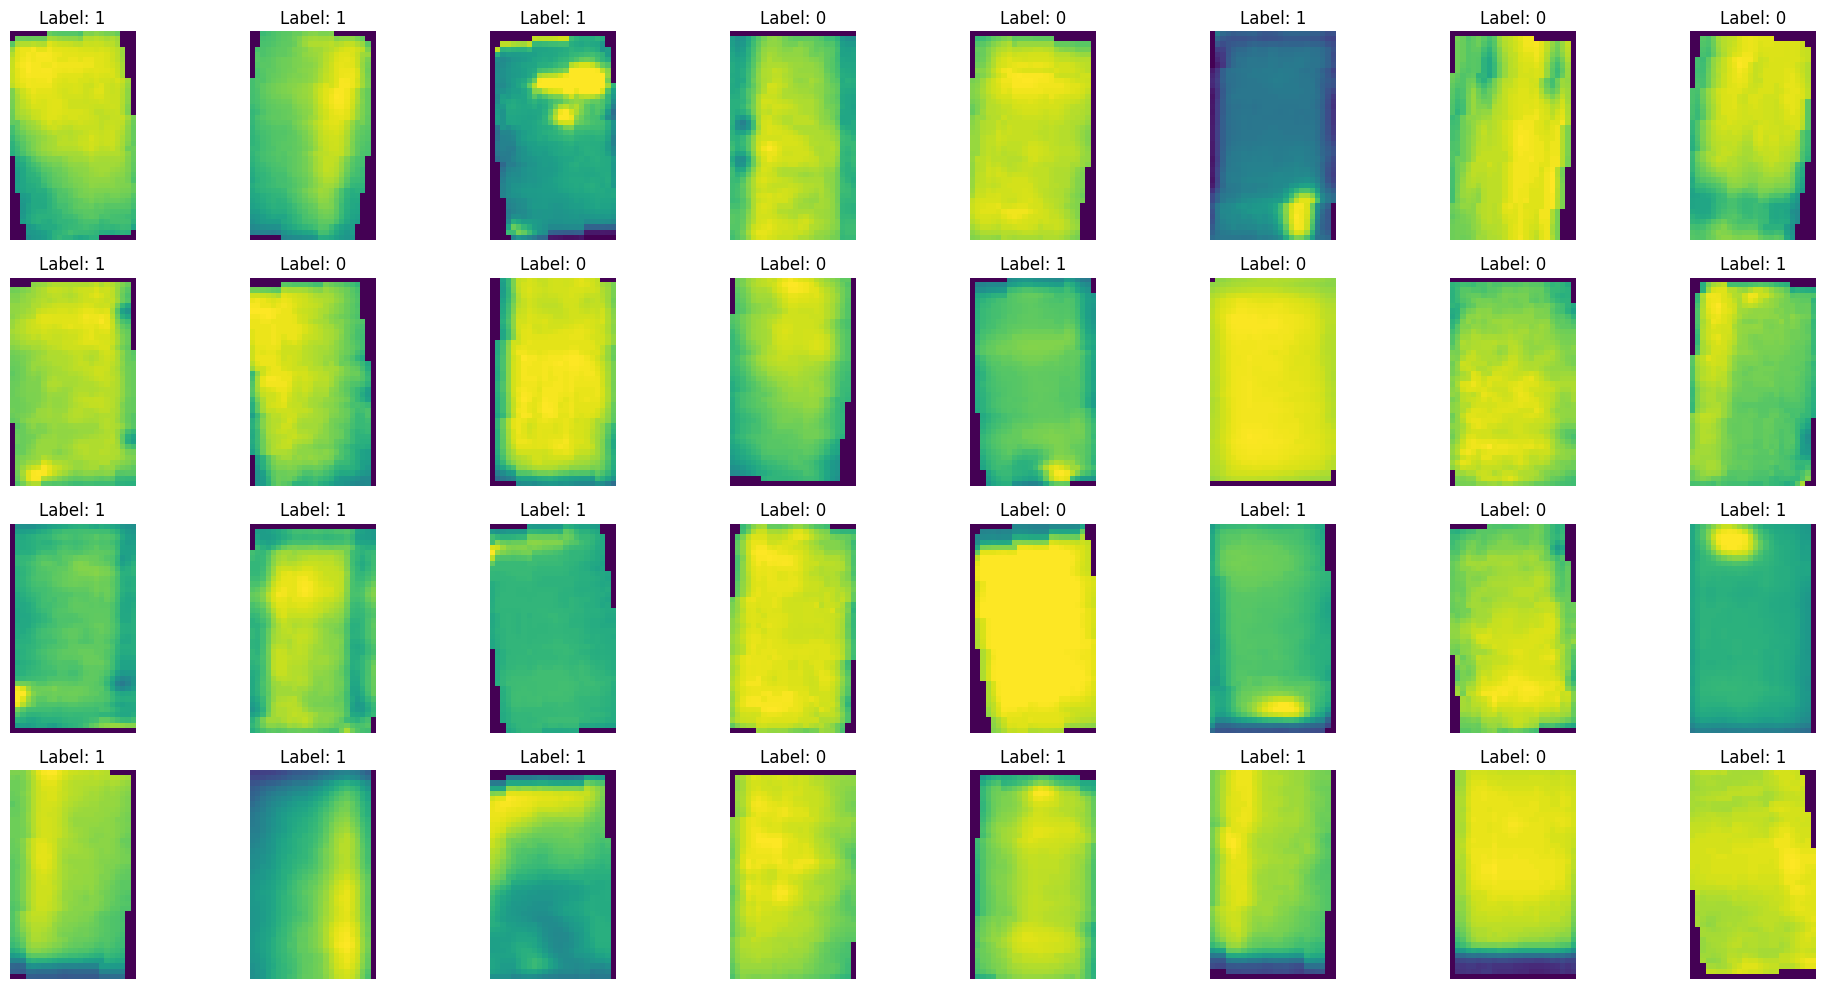

In [ ]:
# Show of 32 images
images, labels = next(iter(train_loader_a))

# Inverse of normalization
images = images * 0.5 + 0.5
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
for i in range(len(images)):
    image = images[i]
    image_pil = transforms.ToPILImage()(image)

    # Exibe a imagem
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

print("Image Size: ", images[0].shape)
plt.tight_layout()
plt.show()

**Convolutional Neural Network**

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional and pooling layers
        self.conv1 = nn.Conv2d(1, 128, 3)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(128, 256, 3)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(256, 512, 3)
        self.bn3 = nn.BatchNorm2d(512)

        self.dropout_conv = nn.Dropout2d(0.2)

        # Calculating the correct input size for the fully connected layer
        # Initial    : (40, 24)
        # After conv1: (38, 22)
        # After pool1: (19, 11)
        # After conv2: (17, 9)
        # After pool2: (8, 4)
        # After conv3: (6, 2)

        self.fc1 = nn.Linear(512 * 6 * 2, 1024)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, 2)

    def forward(self, x):
        # Convolutional layers, ReLU, and pooling
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout_conv(x)
        x = F.relu(self.bn3(self.conv3(x)))

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

model = Network()

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler_a = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

**Train and Test functions**

In [ ]:
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          scheduler,
          device: torch.device,
          num_epochs,
          path_model,
          verbatim):
    model.train()
    model.to(device)
    best_accuracy = 0.0
    best_loss = float('inf')
    best_epoch = 0
    best_f1 = 0.0

    for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):
        train_acc = 0.0
        train_loss = 0.0
        all_preds = []
        all_labels = []
        for ibatch, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            y_pred = model(images)              # | 1. Forward pass
            y_pred = y_pred.squeeze(dim=1)      # |

            loss = loss_fn(y_pred, labels)      # | 2. Calculate and accumulate loss
            train_loss += loss.item()           # |

            optimizer.zero_grad()               # | 3. Optimizer zero grad

            loss.backward()                     # | 4. Loss backward

            optimizer.step()                    # | 5. Optimizer step

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == labels).sum().item() / len(y_pred)

            all_preds.extend(y_pred_class.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = train_loss / len(dataloader)
        train_acc = train_acc / len(dataloader)

        epoch_f1 = f1_score(all_labels, all_preds, average="weighted")

        if train_loss < best_loss or epoch_f1 > best_f1:
            path = str(path_model)
            saveModel(model, path=path)
            best_loss = train_loss
            best_accuracy = train_acc
            best_epoch = epoch
            best_f1 = epoch_f1

        scheduler.step(train_loss) # | Step the scheduler
        if verbatim:
            print(f'Epoch #{epoch}: Loss={train_loss:.4f}, F1-score={epoch_f1:.4f}, Accuracy={train_acc:.4f}')

    return best_loss, best_accuracy, best_epoch, best_f1


In [ ]:
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim=True):

    model.eval()      # | Put model in evaluation mode
    model.to(device)

    test_loss, test_acc = 0, 0
    pred_labels = []
    true_labels = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            y_pred = model(images)                    # | 1. Make predictions

            loss = loss_fn(y_pred, labels)            # | 2. Calculate loss
            test_loss += loss.item()                  # |

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)      # | 3. Calculate accuracy
            test_acc += (y_pred_class == labels).sum().item() / len(y_pred)       # |

            pred_labels.extend(y_pred_class.tolist())                             # | Accumulate predictions and true labels
            true_labels.extend(labels.tolist())                                   # |

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    f1 = f1_score(true_labels, pred_labels, average='weighted')  # Use 'weighted' for class imbalance

    if verbatim:
        print(f"Loss = {test_loss:.4f}, F1-Score = {f1:.4f}, Accuracy = {test_acc:.4f}")

    return pred_labels, test_loss, test_acc, f1


**Train**

In [ ]:
if __name__ == "__main__":

    model = model.to(device)

    # Build our model
    best_loss, best_accuracy, best_epoch, best_f1 = train(model=model,
                                                          dataloader=train_loader_a,
                                                          loss_fn=loss_fn,
                                                          optimizer=optimizer,
                                                          scheduler=scheduler_a,
                                                          device=device,
                                                          num_epochs = 10,
                                                          path_model = str("./myModel_best_A_a_94875.pth"),
                                                          verbatim = True)

**Test**

Loss = 0.1538, F1-Score = 0.9487, Accuracy = 0.9487


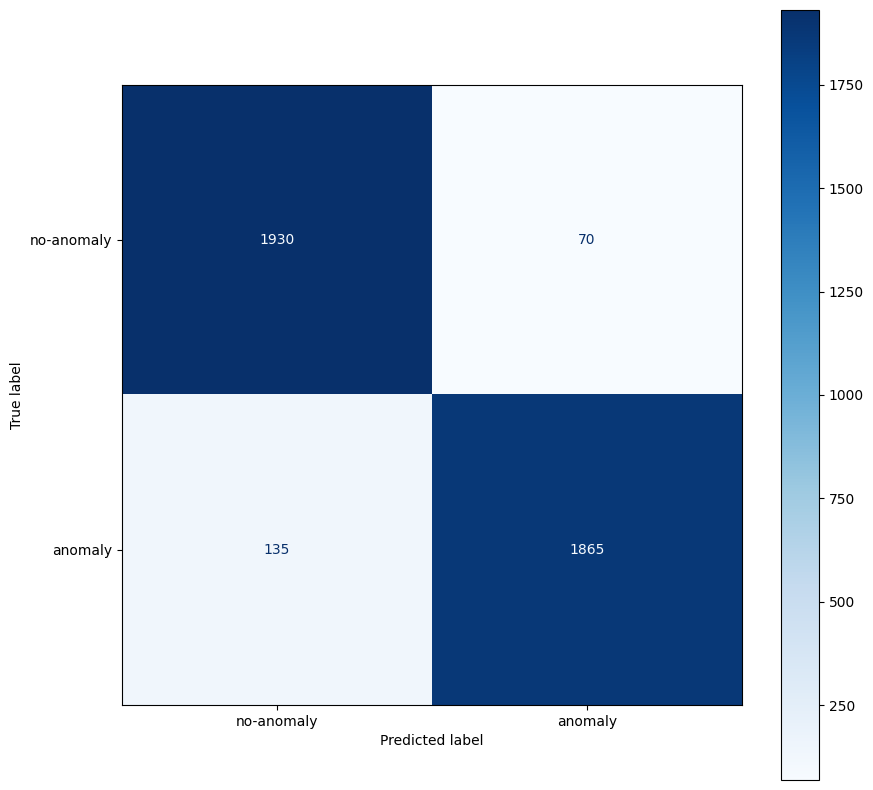

In [ ]:
# Load the model
model = Network()
model = model.to(device)
saved_model_path = "./myModel_best_A_a_94875.pth"
checkpoint = torch.load(saved_model_path, map_location=device, weights_only=True)
model.load_state_dict(checkpoint)
model.eval()

# Perform testing
y_pred_a, test_loss_a, test_acc_a, f1_score_a = test( model=model,
                                                      dataloader=test_loader_a,
                                                      loss_fn=loss_fn,
                                                      device=device,
                                                      verbatim=True)

# Define the confusion matrix plotting function
def plot_confusion_matrix(labels, pred_labels, class_names):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d', cmap='Blues', ax=ax)
    plt.show()

# Plot the confusion matrix
class_names_a = ['no-anomaly', 'anomaly']
plot_confusion_matrix(test_dataset.img_labels, y_pred_a, class_names_a)


## b) Model 2: Classification with 11 anomaly classes (cell, cell-multi, cracking, hotspot, hot-spot-multi, shadowing, diode, diode-multi, vegetation, soiling and offlinemodule)

**Lables assigment and data split**

In [ ]:
df_anomaly = df.copy()

# Filter out the "No-Anomaly" class
df_anomaly = df_anomaly[df_anomaly["anomaly_class"] != "No-Anomaly"]

# Substitution of label to a number
df_anomaly['anomaly_class'] = df_anomaly['anomaly_class'].apply(
    lambda x: 0 if x == 'Cell'
              else 1 if x == 'Cell-Multi'
              else 2 if x == 'Cracking'
              else 3 if x == 'Hot-Spot'
              else 4 if x == 'Hot-Spot-Multi'
              else 5 if x == 'Shadowing'
              else 6 if x == 'Diode'
              else 7 if x == 'Diode-Multi'
              else 8 if x == 'Vegetation'
              else 9 if x == 'Soiling'
              else 10 if x == 'Offline-Module'
              else 11
)

# Print the class distribution
anomaly_counts = df_anomaly['anomaly_class'].value_counts()
print("Counts of each anomaly type:")
print(anomaly_counts)

train_ratio_b = 0.9
train_data_b, test_data_b = train_test_split(df_anomaly, test_size=(1 - train_ratio_b), train_size=train_ratio_b, random_state=2, stratify=df_anomaly['anomaly_class'])

train_data_b.reset_index(drop=True, inplace=True)
test_data_b.reset_index(drop=True, inplace=True)

Counts of each anomaly type:
anomaly_class
0     1877
8     1639
6     1499
1     1288
5     1056
2      940
10     827
3      249
4      246
9      204
7      175
Name: count, dtype: int64


**Transforms**

In [ ]:
# Horizontal flip
transform_augmentation_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Vertical flip
transform_augmentation_2 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])

# Vertical and horizontal flip
transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Train transform
train_transform = transforms.Compose([
    transforms.RandomRotation(10),                          # Random 10 degrees rotation
    transforms.RandomCrop((40, 24), padding=1),             # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2),   # Color jitter
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

# Test transform
test_transform = transforms.Compose([
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

**Augmentation**

In [ ]:
train_data_b_counts = train_data_b['anomaly_class'].value_counts()
print("Counts of each anomaly type(Initial):")
print(train_data_b_counts)
print("\nInitial Size:", len(train_data_b), "\n")

train_data_b_balanced = train_data_b.copy()

largest_class_count = train_data_b_counts.max()                  #
ratios = largest_class_count / train_data_b_counts               #
max_ratio = 4                                                    #
ratios = np.minimum(ratios, max_ratio)                           #
ratios_sorted = ratios.sort_index()                              #
ratios_matrix=[]                                                 # Ratios Calculations
                                                                 #
for label, ratio in ratios_sorted.items():                       #
    ratios_matrix.append([label, ratio])                         #
ratios_matrix[0][1]+=0.1                                         #
print(ratios_matrix)                                             #



directory = "/content/images_b"                                  #
if os.path.exists(directory):                                    #
    for filename in os.listdir(directory):                       #
        file_path = os.path.join(directory, filename)            #
        try:                                                     #
            if os.path.isdir(file_path):                         #
              shutil.rmtree(file_path)                           # Folder creation for new images
            else:                                                #
                os.remove(file_path)                             #
        except Exception as e:                                   #
            print(f"Error deleting file {file_path}: {e}")       #
else:                                                            #
    os.makedirs(directory, exist_ok=True)                        #


#Augmentation
for i in range(len(train_data_b)):
    row = train_data_b.iloc[i]
    image_path = row["image_filepath"]
    label = row["anomaly_class"]

    image_pil = Image.open(image_path).convert("L")

    ratio = ratios_matrix[int(label)][1]

    int_part = int(ratio)
    frac_part = ratio - int_part
    num1,num2 = random.sample(range(1, 3), 2)

    for n in range(int_part-1):
        random_number = random.randint(1, 3)
        if(int_part==1):
            if(random_number==1):
                transform_augmentation = transform_augmentation_1
            elif(random_number==2):
                transform_augmentation = transform_augmentation_2
            elif(random_number==3):
                transform_augmentation = transform_augmentation_3
        elif(int_part==2 and n==0):
            if(num1==1):
                transform_augmentation = transform_augmentation_1
            elif(num1==2):
                transform_augmentation = transform_augmentation_2
            elif(num1==3):
                transform_augmentation = transform_augmentation_3
        elif(int_part==2 and n==1):
            if(num2==1):
                transform_augmentation = transform_augmentation_1
            elif(num2==2):
                transform_augmentation = transform_augmentation_2
            elif(num2==3):
                transform_augmentation = transform_augmentation_3
        elif(int_part==3 and n==0):
            transform_augmentation = transform_augmentation_1
        elif(int_part==3 and n==1):
            transform_augmentation = transform_augmentation_2
        elif(int_part==3 and n==2):
            transform_augmentation = transform_augmentation_3
        elif(int_part==4 and n==0):
            transform_augmentation = transform_augmentation_1
        elif(int_part==4 and n==1):
            transform_augmentation = transform_augmentation_2
        elif(int_part==4 and n==2):
            transform_augmentation = transform_augmentation_3
        elif(int_part==4 and n==3):
            if(random_number==1):
                transform_augmentation = transform_augmentation_1
            elif(random_number==2):
                transform_augmentation = transform_augmentation_2
            elif(random_number==3):
                transform_augmentation = transform_augmentation_3
        transformed_image = transform_augmentation(image_pil)
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_{int(label)}_{i}_{n}.jpg")
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_b_balanced = pd.concat([train_data_b_balanced, pd.DataFrame([new_row])], ignore_index=True)

    # Perform probabilistic augmentation for the fractional part
    if random.random() < frac_part:
        random_number = random.randint(1, 3)
        if(random_number==1):
            transform_augmentation = transform_augmentation_1
        elif(random_number==2):
            transform_augmentation = transform_augmentation_2
        elif(random_number==3):
            transform_augmentation = transform_augmentation_3
        transformed_image = transform_augmentation(image_pil)
        x=1
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_2_{int(label)}_{i}_{x}.jpg")
        x+=1
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_b_balanced = pd.concat([train_data_b_balanced, pd.DataFrame([new_row])], ignore_index=True)


train_data_b_balanced_counts = train_data_b_balanced['anomaly_class'].value_counts()
print("\n\nCounts of each anomaly type(Augmented):")
print(train_data_b_balanced_counts)
print("\nAugmented Size:", len(train_data_b_balanced))

Counts of each anomaly type(Initial):
anomaly_class
0     1689
8     1475
6     1349
1     1159
5      950
2      846
10     744
3      224
4      222
9      184
7      158
Name: count, dtype: int64

Initial Size: 9000 

[[0, 1.1], [1, 1.4572907679033649], [2, 1.99645390070922], [3, 4.0], [4, 4.0], [5, 1.7778947368421052], [6, 1.252038547071905], [7, 4.0], [8, 1.1450847457627118], [9, 4.0], [10, 2.2701612903225805]]


Counts of each anomaly type(Augmented):
anomaly_class
0     1845
1     1693
2     1690
6     1690
8     1684
10    1677
5     1676
3      896
4      888
9      736
7      632
Name: count, dtype: int64

Augmented Size: 15107


**Dataset class**

In [ ]:
class MyImageDataset_b(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):
        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        try:
            img_path = self.img_paths[idx]
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label, dtype=torch.long)
        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")

**Dataloaders**

In [ ]:
train_dataset_b_balanced = MyImageDataset_b(metadata=train_data_b_balanced, transform=train_transform)
test_dataset_b = MyImageDataset_b(metadata=test_data_b, transform=test_transform)

#Batch size
batch_size = 32
train_loader_b = data.DataLoader(dataset=train_dataset_b_balanced, batch_size=batch_size, shuffle=True)
test_loader_b = data.DataLoader(dataset=test_dataset_b, batch_size=batch_size, shuffle=False)

tensor(8)
torch.Size([1, 40, 24])


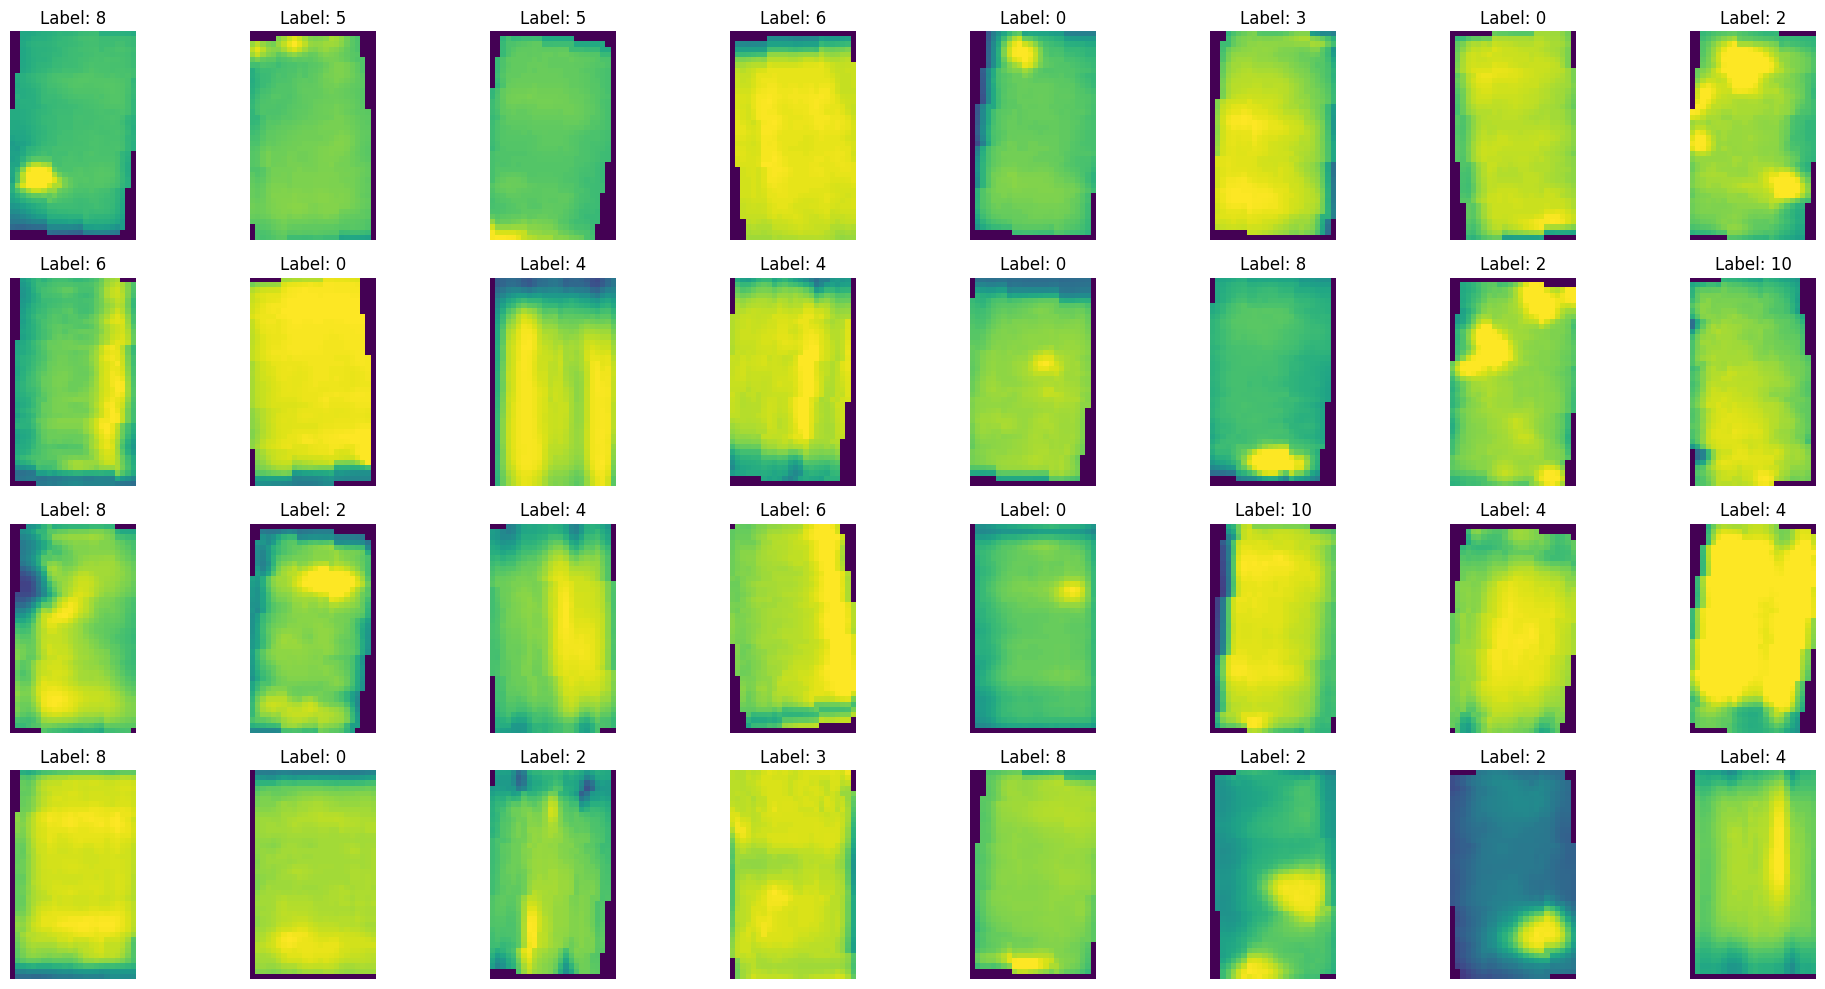

In [ ]:
# Show a batch
images_b, labels_b = next(iter(train_loader_b))
print(labels_b[0])

images_b = images_b * 0.5 + 0.5

fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
for i in range(len(images_b)):
    image = images_b[i]
    image_pil = transforms.ToPILImage()(image)
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels_b[i].item()}")
    axes[i].axis('off')
print(images_b[0].shape)
plt.tight_layout()
plt.show()

**Train and test functions**

In [ ]:
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          num_epochs,
          path_model,
          verbatim):
    model.train()
    model.to(device)
    best_accuracy = 0.0
    best_loss = 0.0
    best_epoch = 0
    for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):
        train_acc = 0.0
        train_loss = 0.0
        for ibatch, (images, labels) in enumerate(dataloader):

            images = images.to(device)
            labels = labels.to(device)

            y_pred = model(images)            # | 1. Forward pass
            y_pred = y_pred.squeeze(dim=1)    # |

            loss = loss_fn(y_pred, labels)    # | 2. Calculate  and accumulate loss
            train_loss += loss.item()         # |

            optimizer.zero_grad()             # | 3. Optimizer zero grad

            loss.backward()                   # | 4. Loss backward

            optimizer.step()                  # | 5. Optimizer step

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

        train_loss = train_loss / len(dataloader)
        train_acc = train_acc / len(dataloader)

        if train_acc > best_accuracy:
            path = str(path_model)
            saveModel(model, path = path)
            best_loss = train_loss
            best_accuracy = train_acc
            best_epoch = epoch
            if verbatim:
              print('Best Epoch #', epoch,' Loss=', best_loss, " Accu=", best_accuracy )

    return best_loss, best_accuracy, best_epoch

In [ ]:
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim=True):

    model.eval()
    model.to(device)

    test_loss, test_acc = 0, 0
    pred_labels = []
    true_labels = []
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            y_pred = model(images)          # | 1. Make predictions

            loss = loss_fn(y_pred, labels)  # | 2. Calculate loss
            test_loss += loss.item()        # |

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)   # | 3. Calculate accuracy
            test_acc += (y_pred_class == labels).sum().item() / len(y_pred)    # |

            pred_labels.extend(y_pred_class.tolist())
            true_labels.extend(labels.tolist())

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    f1 = f1_score(true_labels, pred_labels, average='weighted')
    if verbatim:
        print(f"Loss = {test_loss:.4f}, F1-Score = {f1:.4f}, Accuracy = {test_acc:.4f}")
    return pred_labels, test_loss, test_acc, f1


**Convolution Neural Network**

In [ ]:
class Network_b(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional and pooling layers
        self.conv1 = nn.Conv2d(1, 128, 3)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(128, 256, 3)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 1)

        self.conv3 = nn.Conv2d(256, 512, 3)
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(512, 512, 3)  # Extra layer
        self.bn4 = nn.BatchNorm2d(512)

        self.dropout_conv = nn.Dropout2d(0.2)

        # Calculating the correct input size for the fully connected layer
        # Initial    : (40, 24)
        # After conv1: (38, 22)
        # After pool1: (19, 11)
        # After conv2: (17, 9)
        # After pool2: (16, 8)
        # After conv3: (14, 6)
        # After pool3: (7, 3)
        # After conv4: (5, 1)

        self.fc1 = nn.Linear(512 * 5 * 1, 2048)
        self.bn_fc1 = nn.BatchNorm1d(2048)
        self.dropout1 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(2048, 1024)
        self.bn_fc2 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(1024, 256)
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(256, 11)

    def forward(self, x):
        # First convolutional layer, ReLU, and pooling
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.dropout_conv(x)  # Dropout after conv layers
        x = torch.flatten(x, 1)

        # Fully connected layers
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)

        x = self.fc4(x)

        return x

model_b = Network_b()

class_labels = train_data_b_balanced['anomaly_class'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights /= class_weights.sum()

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fn_b = nn.CrossEntropyLoss(weight=class_weights).to(device)

optimizer_b = torch.optim.Adam(model_b.parameters(), lr=0.0001, weight_decay=5e-4)

**Train**

In [ ]:
if __name__ == "__main__":

    model = model_b.to(device)

    # Build our model
    best_loss, best_accuracy, best_epoch = train(model=model_b,
                                                    dataloader=train_loader_b,
                                                    loss_fn=loss_fn_b,
                                                    optimizer=optimizer_b,
                                                    device=device,
                                                    num_epochs = 20,
                                                    path_model = str("./myModel_best_A_b.pth"),
                                                    verbatim = True)

**Test**

Loss = 0.9153, F1-Score = 0.7256, Accuracy = 0.7324


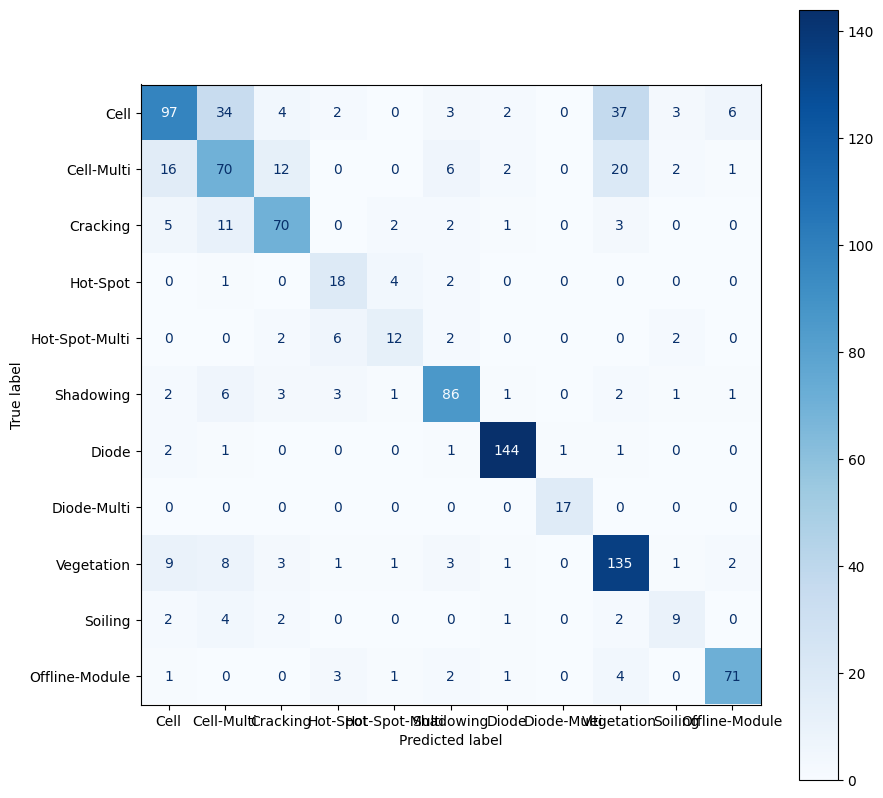

In [ ]:
model_test_b = Network_b()
model_test_b = model_test_b.to(device)

saved_model_path = "./myModel_best_A_b_7324.pth"
checkpoint = torch.load(saved_model_path, map_location=device, weights_only=True)
model_test_b.load_state_dict(checkpoint)
model_test_b.eval()

y_pred_b, test_loss_b, test_acc_b, f1_score_b  = test(model=model_test_b,
                                                      dataloader=test_loader_b,
                                                      loss_fn=loss_fn_b,
                                                      device=device,
                                                      verbatim = True)

def plot_confusion_matrix(labels, pred_labels, class_names):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d', cmap='Blues', ax=ax)
    plt.show()


# Plot the confusion matrix
class_names_b = ['Cell', 'Cell-Multi', 'Cracking', 'Hot-Spot', 'Hot-Spot-Multi', 'Shadowing', 'Diode', 'Diode-Multi', 'Vegetation', 'Soiling', 'Offline-Module']
plot_confusion_matrix(test_dataset_b.img_labels, y_pred_b, class_names_b)

## c)  Model 3: Classification with 12 classes (cell, cell-multi, cracking, hot-spot, hotspot-multi, shadowing, diode, diode-multi, vegetation, soiling, offline-module and no-anomaly)

**Lable assigment and data split**

In [ ]:
# Binary Classification DataFrame
df_all_classes = df.copy()

# Substitution of string lables to numeric
df_all_classes['anomaly_class'] = df_all_classes['anomaly_class'].apply(
    lambda x: 0 if x == 'Cell'
              else 1 if x == 'Cell-Multi'
              else 2 if x == 'Cracking'
              else 3 if x == 'Hot-Spot'
              else 4 if x == 'Hot-Spot-Multi'
              else 5 if x == 'Shadowing'
              else 6 if x == 'Diode'
              else 7 if x == 'Diode-Multi'
              else 8 if x == 'Vegetation'
              else 9 if x == 'Soiling'
              else 10 if x == 'Offline-Module'
              else 11 if x == 'No-Anomaly'
              else 12
)

# Class distribution
df_all_classes_count = df_all_classes['anomaly_class'].value_counts()
print("Counts of each anomaly type:")
print(df_all_classes_count)

#Train/Test ratio and split
train_ratio_c = 0.9
train_data_c, test_data_c = train_test_split(df_all_classes, test_size=(1 - train_ratio_c), train_size=train_ratio_c, random_state=2, stratify=df_all_classes['anomaly_class'])

train_data_c.reset_index(drop=True, inplace=True)
test_data_c.reset_index(drop=True, inplace=True)

Counts of each anomaly type:
anomaly_class
11    10000
0      1877
8      1639
6      1499
1      1288
5      1056
2       940
10      827
3       249
4       246
9       204
7       175
Name: count, dtype: int64


**Transforms**

In [ ]:
# Horizontal flip
transform_augmentation_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Vertical flip
transform_augmentation_2 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])

# Horzontal and Vertical flip
transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Train transform
train_transform = transforms.Compose([
    transforms.RandomRotation(10),                            # Random 10 degrees rotation
    #transforms.RandomCrop((40, 24), padding=1),              # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2),     # Color jitter
    transforms.ToTensor(),                                    # Conversion to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])               # Normalization
])

# Test Transfomr
test_transform = transforms.Compose([
    transforms.ToTensor(),                                    # Conversion to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])               # Normalization
])

**Augmentation**

In [ ]:
train_data_c_counts = train_data_c['anomaly_class'].value_counts()
print("Counts of each anomaly type(Initial):")
print(train_data_c_counts)
print("\nInitial Size:", len(train_data_c), "\n")

# Datasets
train_data_c_balanced = train_data_c.copy()

largest_class_count = train_data_c_counts.max()                     #
ratios = largest_class_count / train_data_c_counts                  #
max_ratio = 4                                                       #
ratios = np.minimum(ratios, max_ratio)                              #
ratios_sorted = ratios.sort_index()                                 # Ratios Calculations
ratios_matrix=[]                                                    #
for label, ratio in ratios_sorted.items():                          #
    ratios_matrix.append([label, ratio])                            #
print(ratios_matrix)                                                #



directory = "/content/images_c"                                     #
if os.path.exists(directory):                                       #
    for filename in os.listdir(directory):                          #
        file_path = os.path.join(directory, filename)               #
        try:                                                        #
            if os.path.isdir(file_path):                            #
                shutil.rmtree(file_path)                            # Folder creation for new images
            else:                                                   #
                os.remove(file_path)                                #
        except Exception as e:                                      #
            print(f"Error deleting file {file_path}: {e}")          #
else:                                                               #
    os.makedirs(directory, exist_ok=True)                           #


# Augmentation
for i in range(len(train_data_c)):
    row = train_data_c.iloc[i]
    image_path = row["image_filepath"]
    label = row["anomaly_class"]

    image_pil = Image.open(image_path).convert("L")

    ratio = ratios_matrix[int(label)][1]

    int_part = int(ratio)
    frac_part = ratio - int_part
    num1,num2 = random.sample(range(1, 3), 2)

    for n in range(int_part-1):
        if(n==0):
            transform_augmentation = transform_augmentation_1
        elif(n==1):
            transform_augmentation = transform_augmentation_2
        elif(n==2):
            transform_augmentation = transform_augmentation_3

        transformed_image = transform_augmentation(image_pil)
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_{int(label)}_{i}_{n}.jpg")
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_c_balanced = pd.concat([train_data_c_balanced, pd.DataFrame([new_row])], ignore_index=True)

train_data_c_balanced_counts = train_data_c_balanced['anomaly_class'].value_counts()
print("\n\nCounts of each anomaly type(Augmented):")
print(train_data_c_balanced_counts)
print("\nAugmented Size:", len(train_data_c_balanced))

Counts of each anomaly type(Initial):
anomaly_class
11    9000
0     1689
8     1475
6     1349
1     1159
5      950
2      846
10     744
3      224
4      222
9      184
7      158
Name: count, dtype: int64

Initial Size: 18000 

[[0, 4.0], [1, 4.0], [2, 4.0], [3, 4.0], [4, 4.0], [5, 4.0], [6, 4.0], [7, 4.0], [8, 4.0], [9, 4.0], [10, 4.0], [11, 1.0]]


Counts of each anomaly type(Augmented):
anomaly_class
11    9000
0     6756
8     5900
6     5396
1     4636
5     3800
2     3384
10    2976
3      896
4      888
9      736
7      632
Name: count, dtype: int64

Augmented Size: 45000


**Image dataset class**

In [ ]:
class MyImageDataset_c(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        try:
            img_path = self.img_paths[idx]

            # Ensure the image file exists
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            # Open and convert the image
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]

            # Apply transformations if specified
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")

**Data loaders**

In [ ]:
# DataLoaders
train_dataset_c_balanced = MyImageDataset_c(metadata=train_data_c_balanced, transform=train_transform)
test_dataset_c = MyImageDataset_c(metadata=test_data_c, transform=test_transform)

batch_size = 32
train_loader_c = data.DataLoader(dataset=train_dataset_c_balanced, batch_size=batch_size, shuffle=True)
test_loader_c = data.DataLoader(dataset=test_dataset_c, batch_size=batch_size, shuffle=False)

Image size torch.Size([1, 40, 24])


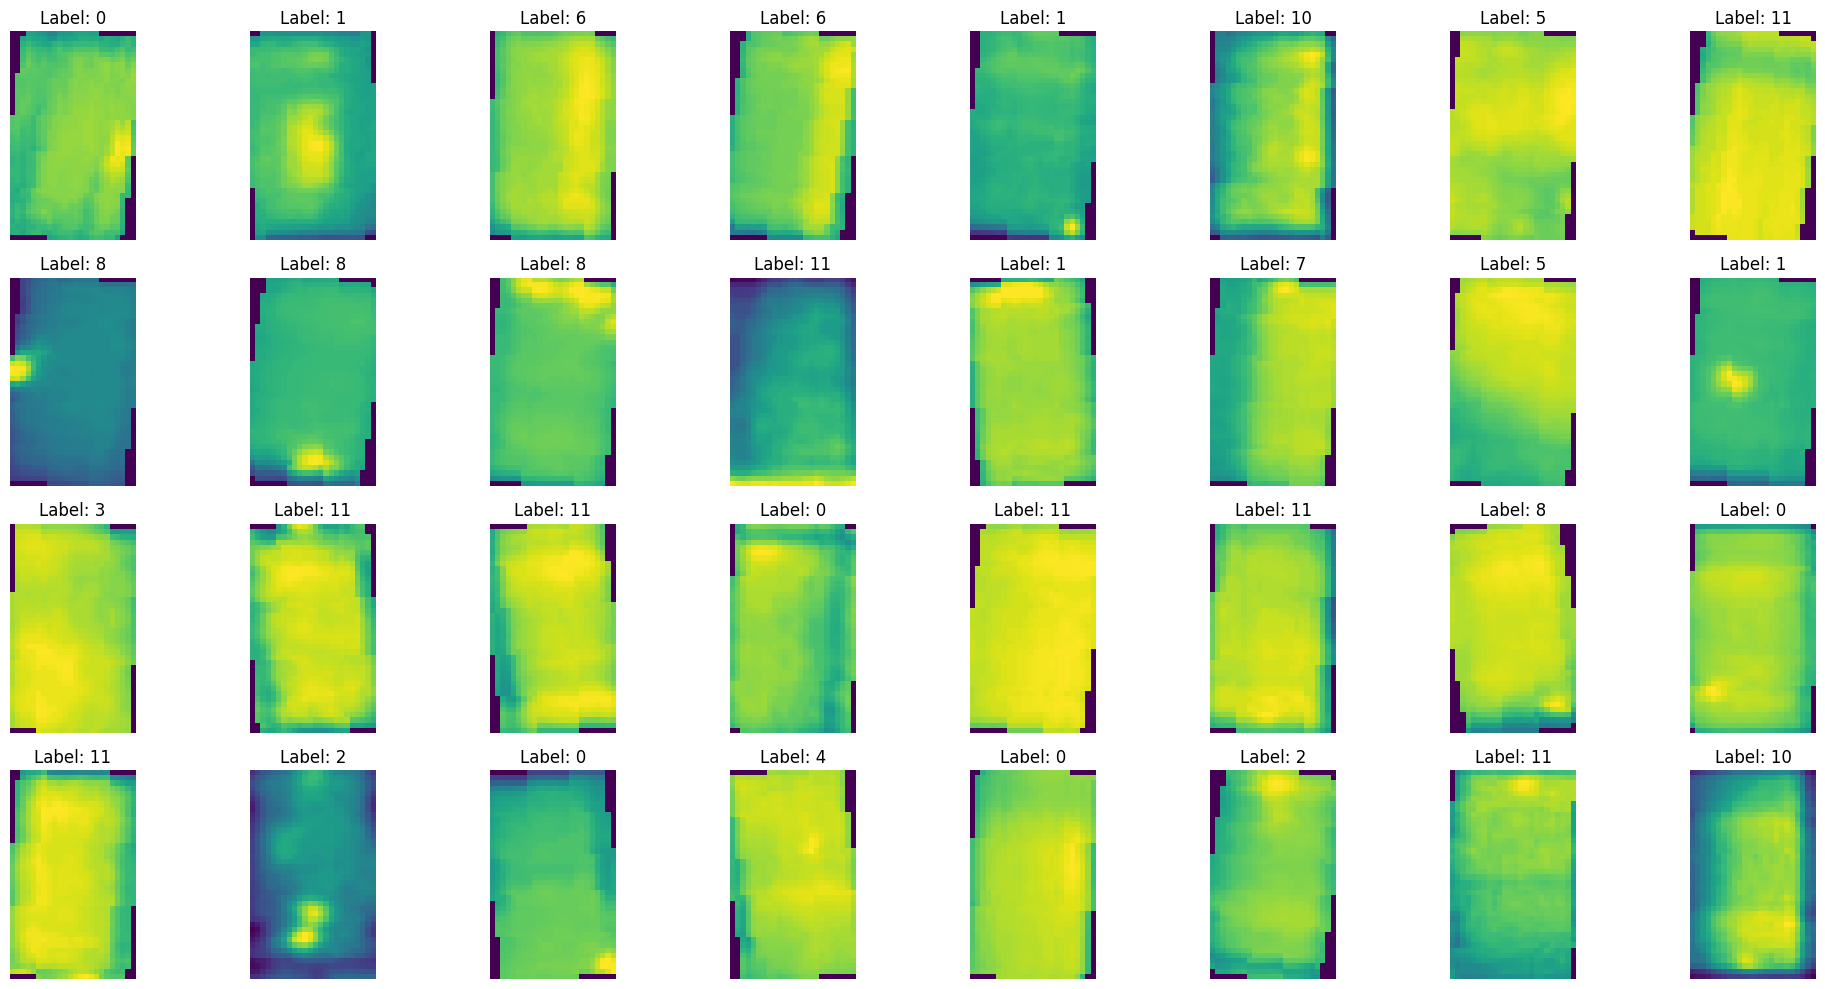

In [ ]:
# Show of a batch
images_c, labels_c = next(iter(train_loader_c))
images_c = images_c * 0.5 + 0.5

fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
for i in range(len(images_c)):
    image = images_c[i]
    image_pil = transforms.ToPILImage()(image)
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels_c[i].item()}")
    axes[i].axis('off')

print("Image size", images_c[0].shape)
plt.tight_layout()
plt.show()

**Train and test functions**

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          scheduler,
          device: torch.device,
          num_epochs,
          path_model,
          verbatim):
    model.train()
    model.to(device)
    best_accuracy = 0.0
    best_loss = float('inf')
    best_epoch = 0
    best_f1 = 0.0
    for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):
        train_acc = 0.0
        train_loss = 0.0
        all_preds = []
        all_labels = []
        for ibatch, (images, labels) in enumerate(dataloader):

            images = images.to(device)
            labels = labels.to(device)

            y_pred = model(images)            # | 1. Forward pass
            y_pred = y_pred.squeeze(dim=1)    # |

            loss = loss_fn(y_pred, labels)    # | 2. Calculate and accumulate loss
            train_loss += loss.item()         # |

            optimizer.zero_grad()             # | 3. Optimizer zero grad

            loss.backward()                   # | 4. Loss backward

            optimizer.step()                  # | 5. Optimizer step

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == labels).sum().item() / len(y_pred)

            all_preds.extend(y_pred_class.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = train_loss / len(dataloader)
        train_acc = train_acc / len(dataloader)
        epoch_f1 = f1_score(all_labels, all_preds, average="weighted")

        if train_loss < best_loss or epoch_f1 > best_f1:
            path = str(path_model)
            saveModel(model, path=path)
            best_loss = train_loss
            best_accuracy = train_acc
            best_epoch = epoch
            best_f1 = epoch_f1

        scheduler.step(train_loss)  # | Step the scheduler
        if verbatim:
            print(f'Epoch #{epoch}: Loss={train_loss:.4f}, F1-score={epoch_f1:.4f}, Accuracy={train_acc:.4f}')
    return best_loss, best_accuracy, best_epoch, best_f1


In [ ]:
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim=True):
    model.eval()
    model.to(device)

    test_loss, test_acc = 0, 0
    pred_labels = []
    true_labels = []
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            y_pred = model(images)          # | 1. Make predictions

            loss = loss_fn(y_pred, labels)  # | 2. Calculate loss
            test_loss += loss.item()        # |

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == labels).sum().item() / len(y_pred)

            pred_labels.extend(y_pred_class.tolist())
            true_labels.extend(labels.tolist())

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    f1 = f1_score(true_labels, pred_labels, average='weighted')
    if verbatim:
        print(f"Loss = {test_loss:.4f}, F1-Score = {f1:.4f}, Accuracy = {test_acc:.4f}")
    return pred_labels, test_loss, test_acc, f1


**Convolutional Neural Network**

In [ ]:
class Network_c(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional and pooling layers
        self.conv1 = nn.Conv2d(1, 128, 3)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(128, 256, 3)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 1)

        self.conv3 = nn.Conv2d(256, 512, 3)
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(512, 512, 3)
        self.bn4 = nn.BatchNorm2d(512)

        self.dropout_conv = nn.Dropout2d(0.2)

        # Calculating the correct input size for the fully connected layer
        # Initial    : (40, 24)
        # After conv1: (38, 22)
        # After pool1: (19, 11)
        # After conv2: (17, 9)
        # After pool2: (16, 8)
        # After conv3: (14, 6)
        # After pool3: (7, 3)
        # After conv4: (5, 1)

        self.fc1 = nn.Linear(512 * 5 * 1, 2048)
        self.bn_fc1 = nn.BatchNorm1d(2048)
        self.dropout1 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(2048, 1024)
        self.bn_fc2 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(1024, 256)
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(256, 12)

    def forward(self, x):
        # First convolutional layer, ReLU, and pooling
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = F.relu(self.bn4(self.conv4(x)))

        x = self.dropout_conv(x)
        x = torch.flatten(x, 1)

        # Fully connected layers
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout2(x)

        x = F.relu(self.fc3(x))
        x = self.dropout3(x)

        x = self.fc4(x)

        return x

model_c = Network_c()

class_labels = train_data_c_balanced['anomaly_class'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights /= class_weights.sum()

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fn_c = nn.CrossEntropyLoss(weight=class_weights).to(device)

optimizer_c = torch.optim.Adam(model_c.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler_c = ReduceLROnPlateau(optimizer_c, mode='min', factor=0.1, patience=5)

**Train**

In [ ]:
if __name__ == "__main__":

    model = model_c.to(device)

    # Build our model
    best_loss, best_accuracy, best_epoch, best_f1 = train(model=model_c,
                                                          dataloader=train_loader_c,
                                                          loss_fn=loss_fn_c,
                                                          optimizer=optimizer_c,
                                                          scheduler=scheduler_c,
                                                          device=device,
                                                          num_epochs = 30,
                                                          path_model = str("./myModel_best_A_c_78.pth"),
                                                          verbatim = True)

**Test**

Loss = 0.8884, F1-Score = 0.8137, Accuracy = 0.8140


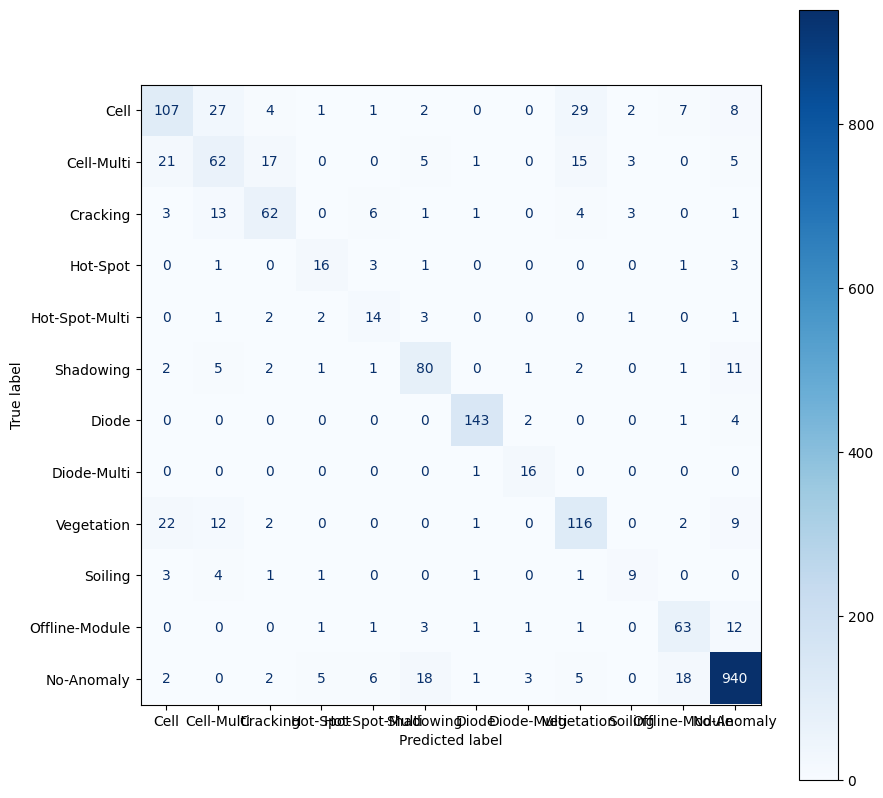

In [ ]:
model_test_c = Network_c()
model_test_c = model_test_c.to(device)

saved_model_path = "./myModel_best_A_c_81.pth"
checkpoint = torch.load(saved_model_path, map_location=device, weights_only=True)
model_test_c.load_state_dict(checkpoint)
model_test_c.eval()

y_preds_c, test_loss_c, test_acc_c, test_f1_c  = test(model=model_test_c,
                                                dataloader=test_loader_c,
                                                loss_fn=loss_fn_c,
                                                device=device,
                                                verbatim = True)

def plot_confusion_matrix(labels, pred_labels, class_names):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d', cmap='Blues', ax=ax)
    plt.show()


# Plot the confusion matrix
class_names_c = ['Cell', 'Cell-Multi', 'Cracking', 'Hot-Spot', 'Hot-Spot-Multi', 'Shadowing', 'Diode', 'Diode-Multi', 'Vegetation', 'Soiling', 'Offline-Module', 'No-Anomaly']
plot_confusion_matrix(test_dataset_c.img_labels, y_preds_c, class_names_c)

#2

## Dataset Augmentation Details

To enhance the dataset and improve model robustness, a series of augmentation transformations were applied to each image in the dataset:

- **Flipping Transformations:** Each image underwent one of three flipping operations:
  - Vertical flip
  - Horizontal flip
  - Combined vertical and horizontal flip

  These operations effectively quadruple the dataset size by introducing variations in orientation.

- **Additional Augmentations:** All original and flipped images were further processed using the following transformations:
  - **Random Rotation:** Applied with a maximum range of $\pm 10^\circ$.
  - **Color Jittering:** Adjustments to brightness and contrast with random variation parameters (brightness and contrast $\pm 20\%$).
  - **Random Cropping:** Images were cropped to target dimensions with optional padding.

This augmentation strategy is designed to introduce variability into the dataset while preserving the essential characteristics of the images, thereby improving the generalization capability of the model.


# 3

Compare the results of your AI-model with at least 1 existing models. In this case **EfficientNet**.

MobileNet is a optimized model that balances model size and accuracy. It uses a novel scaling method to efficiently use resources by adjusting the depth, width, and resolution of the network. It provides excellent performance, often outperforming models like VGG, ResNet, and MobileNet on standard image classification tasks (even on smaller datasets). It's more efficient and accurate than MobileNet while still being relatively lightweight. You can choose from various versions of EfficientNet (like EfficientNet-B0, B1, B2, etc.) depending on your trade-off between speed and accuracy.

When to Use:

If you want a highly efficient model with state-of-the-art performance that can give you good accuracy without requiring extensive computational resources.
If your goal is to balance accuracy and resource usage (without compromising too much on either), EfficientNet is an excellent choice, especially for small image sizes like 40x24.

## a)

In [ ]:
df_binary = df.copy()

# Substitution of the labels: anomaly->1 and no_anomaly->0
df_binary['anomaly_class'] = df_binary['anomaly_class'].apply(
    lambda x: 1 if x.lower() != 'no-anomaly' else 0
)

print(df_binary.tail(4))
print("\nDataset size:", df_binary.shape[0])

# Train/Test ratio
train_ratio_3a = 0.8
train_data_3a, test_data_3a = train_test_split(df_binary, test_size=(1-train_ratio_3a), train_size=train_ratio_3a, random_state=11, stratify=df_binary['anomaly_class'])

train_data_3a.reset_index(drop=True, inplace=True)
test_data_3a.reset_index(drop=True, inplace=True)


         image_filepath  anomaly_class
8489    images/8489.jpg              1
7464    images/7464.jpg              1
18065  images/18065.jpg              0
13354  images/13354.jpg              0

Dataset size: 20000


In [ ]:
class MyImageDataset(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        try:
            img_path = self.img_paths[idx]
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label, dtype=torch.long)
        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")


In [ ]:
# Horizontal flip
transform_augmentation_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Vertical flip
transform_augmentation_2 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])

# Horizontal and Vertical flip
transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Train transform
train_transform = transforms.Compose([
    transforms.RandomRotation(10),                          # Random rotation of 10 degrees
    transforms.RandomCrop((40, 24), padding=1),             # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2),   # Color jitter
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

# Test transform
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

In [ ]:
# Initial dataset size
train_data_3a_counts = train_data_3a['anomaly_class'].value_counts()
print("Counts of each anomaly type(Initial):")
print(train_data_3a_counts)
print("\nInitial Size:", len(train_data_3a), "\n")

train_data_3a_balanced = train_data_3a.copy()

# Folder creation for new images
directory = "/content/images_3a"
if os.path.exists(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isdir(file_path):
                shutil.rmtree(file_path)
            else:
                os.remove(file_path)
        except Exception as e:
            print(f"Error deleting file {file_path}: {e}")
else:
    os.makedirs(directory, exist_ok=True)



for i in range(len(train_data_3a)):
    row = train_data_3a.iloc[i]
    image_path = row["image_filepath"]
    label = row["anomaly_class"]

    image_pil = Image.open(image_path).convert("L")

    # Perform augmentations
    for n in range(3):
        if(n==0):
          transform_augmentation = transform_augmentation_1
        if(n==1):
          transform_augmentation = transform_augmentation_2
        if(n==2):
          transform_augmentation = transform_augmentation_3

        transformed_image = transform_augmentation(image_pil)
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_{int(label)}_{i}_{n}.jpg")
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_3a_balanced = pd.concat([train_data_3a_balanced, pd.DataFrame([new_row])], ignore_index=True)

# Final dataset size
train_data_3a_balanced_counts = train_data_3a_balanced['anomaly_class'].value_counts()
print("\n\nCount of each anomaly type(Augmented):")
print(train_data_3a_balanced_counts)
print("\nAugmented Size:", len(train_data_3a_balanced))

Counts of each anomaly type(Initial):
anomaly_class
1    8000
0    8000
Name: count, dtype: int64

Initial Size: 16000 



Count of each anomaly type(Augmented):
anomaly_class
1    32000
0    32000
Name: count, dtype: int64

Augmented Size: 64000


In [ ]:
# DataLoaders
train_dataset_3a_balanced = MyImageDataset(metadata=train_data_3a_balanced, transform=train_transform)
test_dataset_3a = MyImageDataset(metadata=test_data_3a, transform=test_transform)

#Batch size
batch_size_3a = 32
train_loader_3a = data.DataLoader(dataset=train_dataset_3a_balanced, batch_size=batch_size_3a, shuffle=True)
test_loader_3a = data.DataLoader(dataset=test_dataset_3a, batch_size=batch_size_3a, shuffle=False)

Image Size:  torch.Size([1, 224, 224])


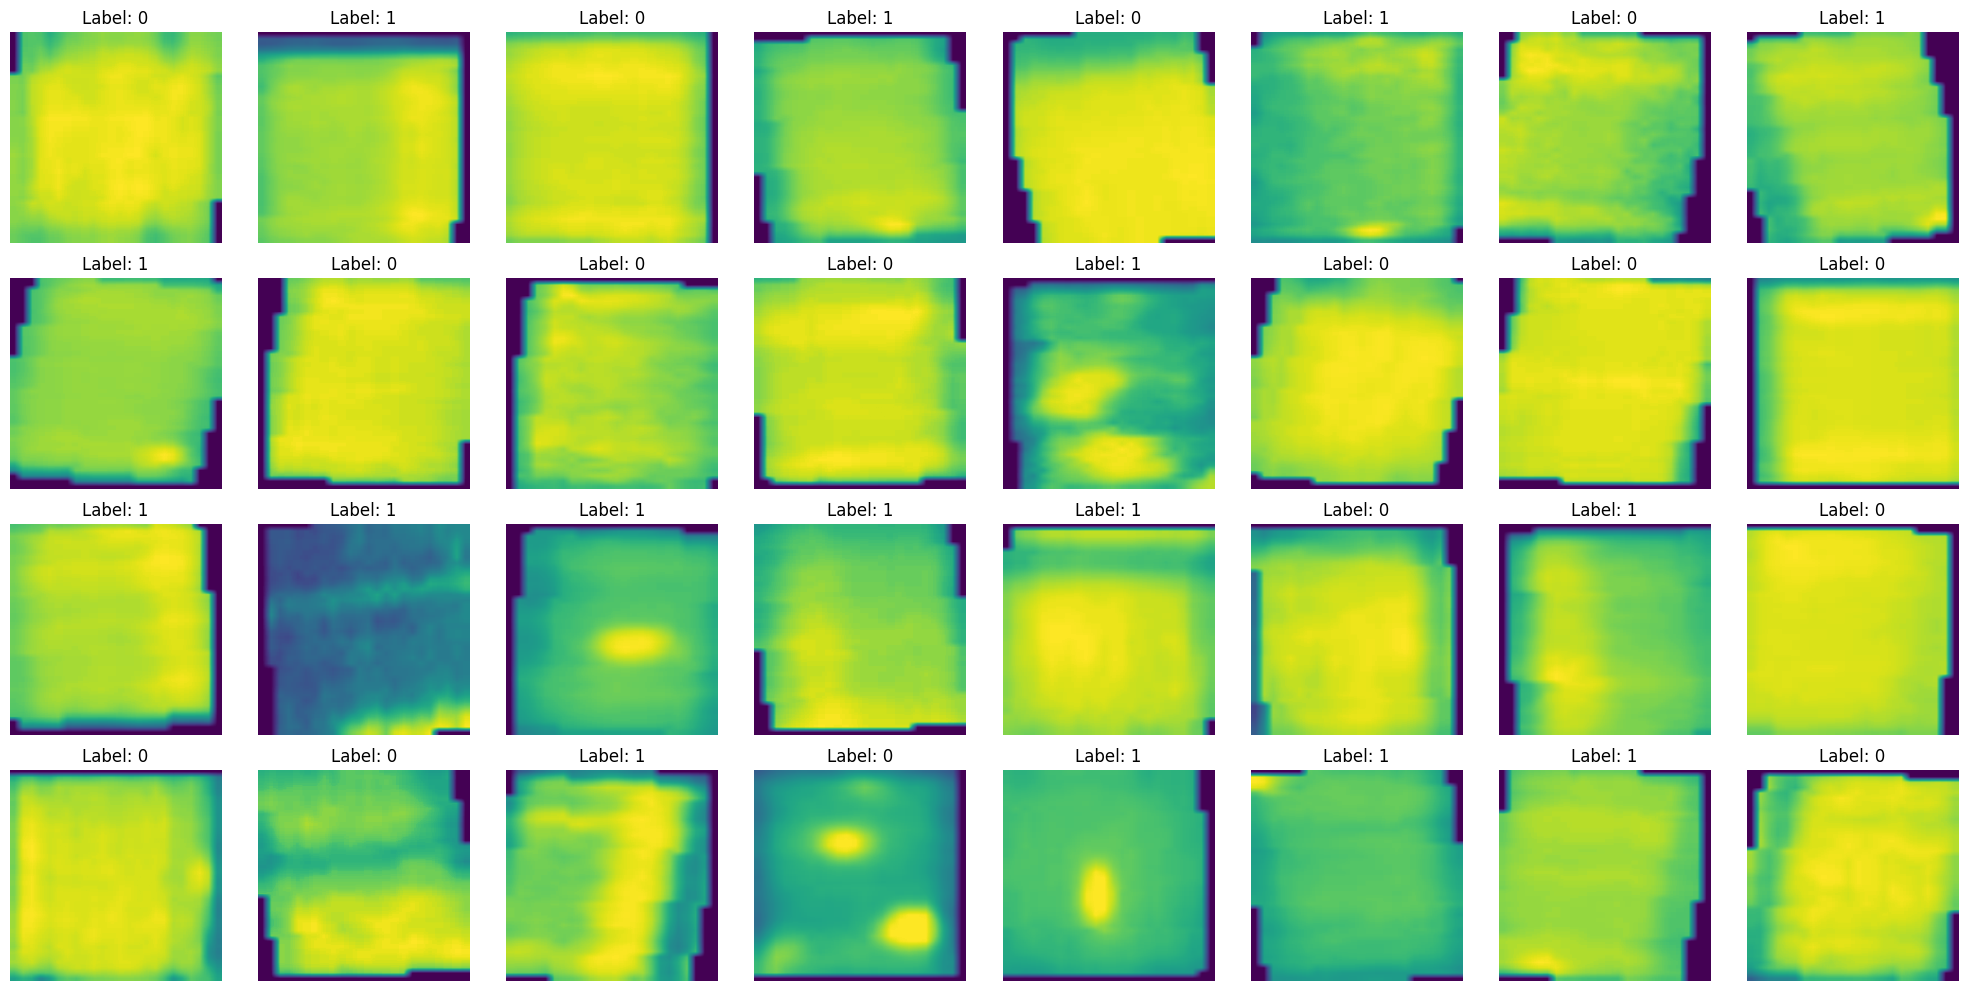

In [ ]:
# Show of 32 images
images, labels = next(iter(train_loader_3a))

# Inverse of normalization
images = images * 0.5 + 0.5
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
for i in range(len(images)):
    image = images[i]
    image_pil = transforms.ToPILImage()(image)

    # Exibe a imagem
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

print("Image Size: ", images[0].shape)
plt.tight_layout()
plt.show()

In [ ]:
efficientnet_model_3a = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the first convolutional layer to accept grayscale images (1 channel)
# EfficientNet expects 3 channels, so we modify the first conv layer to accept 1 channel input
efficientnet_model_3a._conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Modify the final classification layer for 12 classes
efficientnet_model_3a._fc = nn.Linear(efficientnet_model_3a._fc.in_features, 2)

# Send the model to the device (GPU or CPU)
efficientnet_model_3a = efficientnet_model_3a.to(device)

# Compute class weights based on class distribution
class_labels = train_data_3a_balanced['anomaly_class'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights /= class_weights.sum()

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define loss function and optimizer
loss_fn_efficientnet_3a = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer_efficientnet_3a = optim.Adam(efficientnet_model_3a.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler_efficientnet_3a = ReduceLROnPlateau(optimizer_efficientnet_3a, mode='min', factor=0.1, patience=5)


Loaded pretrained weights for efficientnet-b0


In [ ]:
def train(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    avg_loss = train_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy

In [ ]:
def test(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_loss = test_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy, y_true, y_pred

In [ ]:
# Training loop
import time

num_epochs = 20
best_accuracy = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_accuracy = train(efficientnet_model_3a, train_loader_3a, loss_fn_efficientnet_3a, optimizer_efficientnet_3a, device)
    test_loss, test_accuracy, _, _ = test(efficientnet_model_3a, test_loader_3a, loss_fn_efficientnet_3a, device)

    # Step scheduler
    scheduler_efficientnet_3a.step(test_loss)

    # Save the best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(efficientnet_model_3a.state_dict(), "efficientnet_best_model_gray.pth")

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch time: {epoch_time:.2f} seconds\n")

<ipython-input-28-754ffbd45361>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientnet_model_3a.load_state_dict(torch.load("efficientnet_best_model_gray.pth"))


EfficientNet Test Accuracy: 0.948

Confusion Matrix for EfficientNet:


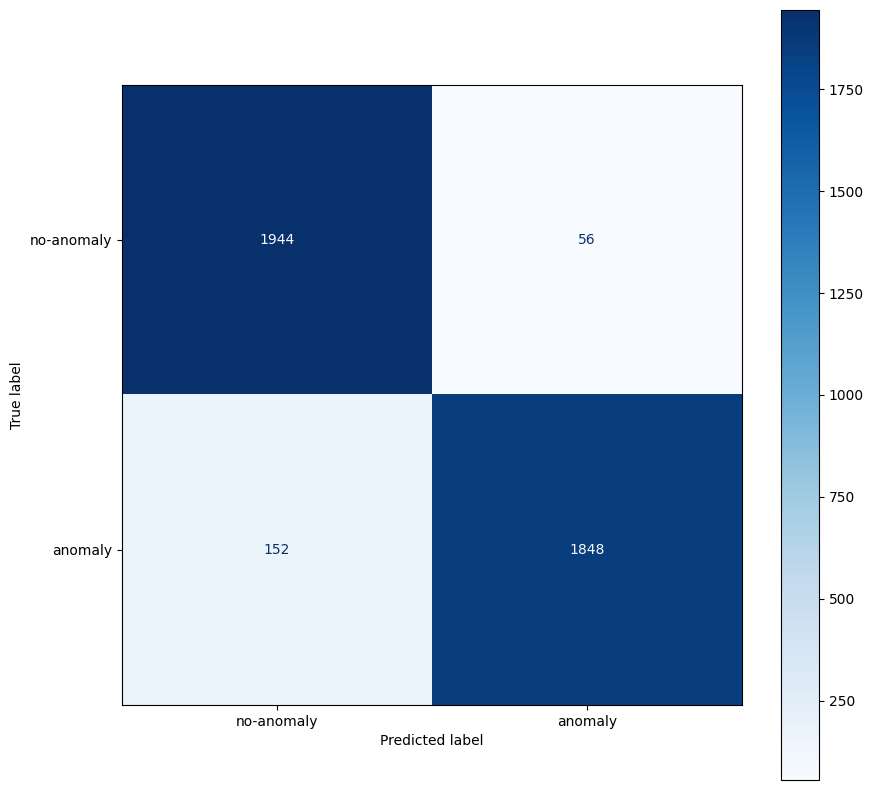

In [ ]:
# Load the best model
efficientnet_model_3a.load_state_dict(torch.load("efficientnet_best_model_gray.pth"))

# Test the model
test_loss_efficientnet_3a, test_accuracy_efficientnet_3a, y_true_efficientnet_3a, y_pred_efficientnet_3a = test(
    efficientnet_model_3a, test_loader_3a, loss_fn_efficientnet_3a, device
)

print("EfficientNet Test Accuracy:", test_accuracy_efficientnet_3a)

# Function to plot confusion matrix
def plot_confusion_matrix(labels, pred_labels, class_names):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d', cmap='Blues', ax=ax)
    plt.show()

class_names_3a = ['no-anomaly', 'anomaly']

# Plot confusion matrix for EfficientNet
print("\nConfusion Matrix for EfficientNet:")
plot_confusion_matrix(y_true_efficientnet_3a, y_pred_efficientnet_3a, class_names_3a)

## c)

In [ ]:
# Binary Classification DataFrame
df_all_classes = df.copy()

# Substitution of string lables to numeric
df_all_classes['anomaly_class'] = df_all_classes['anomaly_class'].apply(
    lambda x: 0 if x == 'Cell'
              else 1 if x == 'Cell-Multi'
              else 2 if x == 'Cracking'
              else 3 if x == 'Hot-Spot'
              else 4 if x == 'Hot-Spot-Multi'
              else 5 if x == 'Shadowing'
              else 6 if x == 'Diode'
              else 7 if x == 'Diode-Multi'
              else 8 if x == 'Vegetation'
              else 9 if x == 'Soiling'
              else 10 if x == 'Offline-Module'
              else 11 if x == 'No-Anomaly'
              else 12
)

# Class distribution
df_all_classes_count = df_all_classes['anomaly_class'].value_counts()
print("Counts of each anomaly type:")
print(df_all_classes_count)

#Train/Test ratio and split
train_ratio_3 = 0.9
train_data_3, test_data_3 = train_test_split(df_all_classes, test_size=(1 - train_ratio_3), train_size=train_ratio_3, random_state=2, stratify=df_all_classes['anomaly_class'])

train_data_3.reset_index(drop=True, inplace=True)
test_data_3.reset_index(drop=True, inplace=True)

Counts of each anomaly type:
anomaly_class
11    10000
0      1877
8      1639
6      1499
1      1288
5      1056
2       940
10      827
3       249
4       246
9       204
7       175
Name: count, dtype: int64


In [ ]:
# Horizontal flip
transform_augmentation_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Vertical flip
transform_augmentation_2 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])

# Horzontal and Vertical flip
transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Train transform
train_transform = transforms.Compose([
    transforms.RandomRotation(10),                            # Random 10 degrees rotation
    #transforms.RandomCrop((40, 24), padding=1),              # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2),     # Color jitter
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                                    # Conversion to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])               # Normalization
])

# Test Transfomr
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                                    # Conversion to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])               # Normalization
])

In [ ]:
train_data_3_counts = train_data_3['anomaly_class'].value_counts()
print("Counts of each anomaly type(Initial):")
print(train_data_3_counts)
print("\nInitial Size:", len(train_data_3), "\n")

# Datasets
train_data_3_balanced = train_data_3.copy()

largest_class_count = train_data_3_counts.max()                     #
ratios = largest_class_count / train_data_3_counts                  #
max_ratio = 4                                                       #
ratios = np.minimum(ratios, max_ratio)                              #
ratios_sorted = ratios.sort_index()                                 # Ratios Calculations
ratios_matrix=[]                                                    #
for label, ratio in ratios_sorted.items():                          #
    ratios_matrix.append([label, ratio])                            #
print(ratios_matrix)                                                #



directory = "/content/images_3"                                     #
if os.path.exists(directory):                                       #
    for filename in os.listdir(directory):                          #
        file_path = os.path.join(directory, filename)               #
        try:                                                        #
            if os.path.isdir(file_path):                            #
                shutil.rmtree(file_path)                            # Folder creation for new images
            else:                                                   #
                os.remove(file_path)                                #
        except Exception as e:                                      #
            print(f"Error deleting file {file_path}: {e}")          #
else:                                                               #
    os.makedirs(directory, exist_ok=True)                           #


# Augmentation
for i in range(len(train_data_3)):
    row = train_data_3.iloc[i]
    image_path = row["image_filepath"]
    label = row["anomaly_class"]

    image_pil = Image.open(image_path).convert("L")

    ratio = ratios_matrix[int(label)][1]

    int_part = int(ratio)
    frac_part = ratio - int_part
    num1,num2 = random.sample(range(1, 3), 2)

    for n in range(int_part-1):
        if(n==0):
            transform_augmentation = transform_augmentation_1
        elif(n==1):
            transform_augmentation = transform_augmentation_2
        elif(n==2):
            transform_augmentation = transform_augmentation_3

        transformed_image = transform_augmentation(image_pil)
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_{int(label)}_{i}_{n}.jpg")
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_3_balanced = pd.concat([train_data_3_balanced, pd.DataFrame([new_row])], ignore_index=True)

train_data_3_balanced_counts = train_data_3_balanced['anomaly_class'].value_counts()
print("\n\nCounts of each anomaly type(Augmented):")
print(train_data_3_balanced_counts)
print("\nAugmented Size:", len(train_data_3_balanced))

Counts of each anomaly type(Initial):
anomaly_class
11    9000
0     1689
8     1475
6     1349
1     1159
5      950
2      846
10     744
3      224
4      222
9      184
7      158
Name: count, dtype: int64

Initial Size: 18000 

[[0, 4.0], [1, 4.0], [2, 4.0], [3, 4.0], [4, 4.0], [5, 4.0], [6, 4.0], [7, 4.0], [8, 4.0], [9, 4.0], [10, 4.0], [11, 1.0]]


Counts of each anomaly type(Augmented):
anomaly_class
11    9000
0     6756
8     5900
6     5396
1     4636
5     3800
2     3384
10    2976
3      896
4      888
9      736
7      632
Name: count, dtype: int64

Augmented Size: 45000


In [ ]:
class MyImageDataset_c(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        try:
            img_path = self.img_paths[idx]

            # Ensure the image file exists
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            # Open and convert the image
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]

            # Apply transformations if specified
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")

In [ ]:
# DataLoaders
train_dataset_3_balanced = MyImageDataset_c(metadata=train_data_3_balanced, transform=train_transform)
test_dataset_3 = MyImageDataset_c(metadata=test_data_3, transform=test_transform)

batch_size = 32
train_loader_3 = data.DataLoader(dataset=train_dataset_3_balanced, batch_size=batch_size, shuffle=True)
test_loader_3 = data.DataLoader(dataset=test_dataset_3, batch_size=batch_size, shuffle=False)

Image size torch.Size([1, 224, 224])


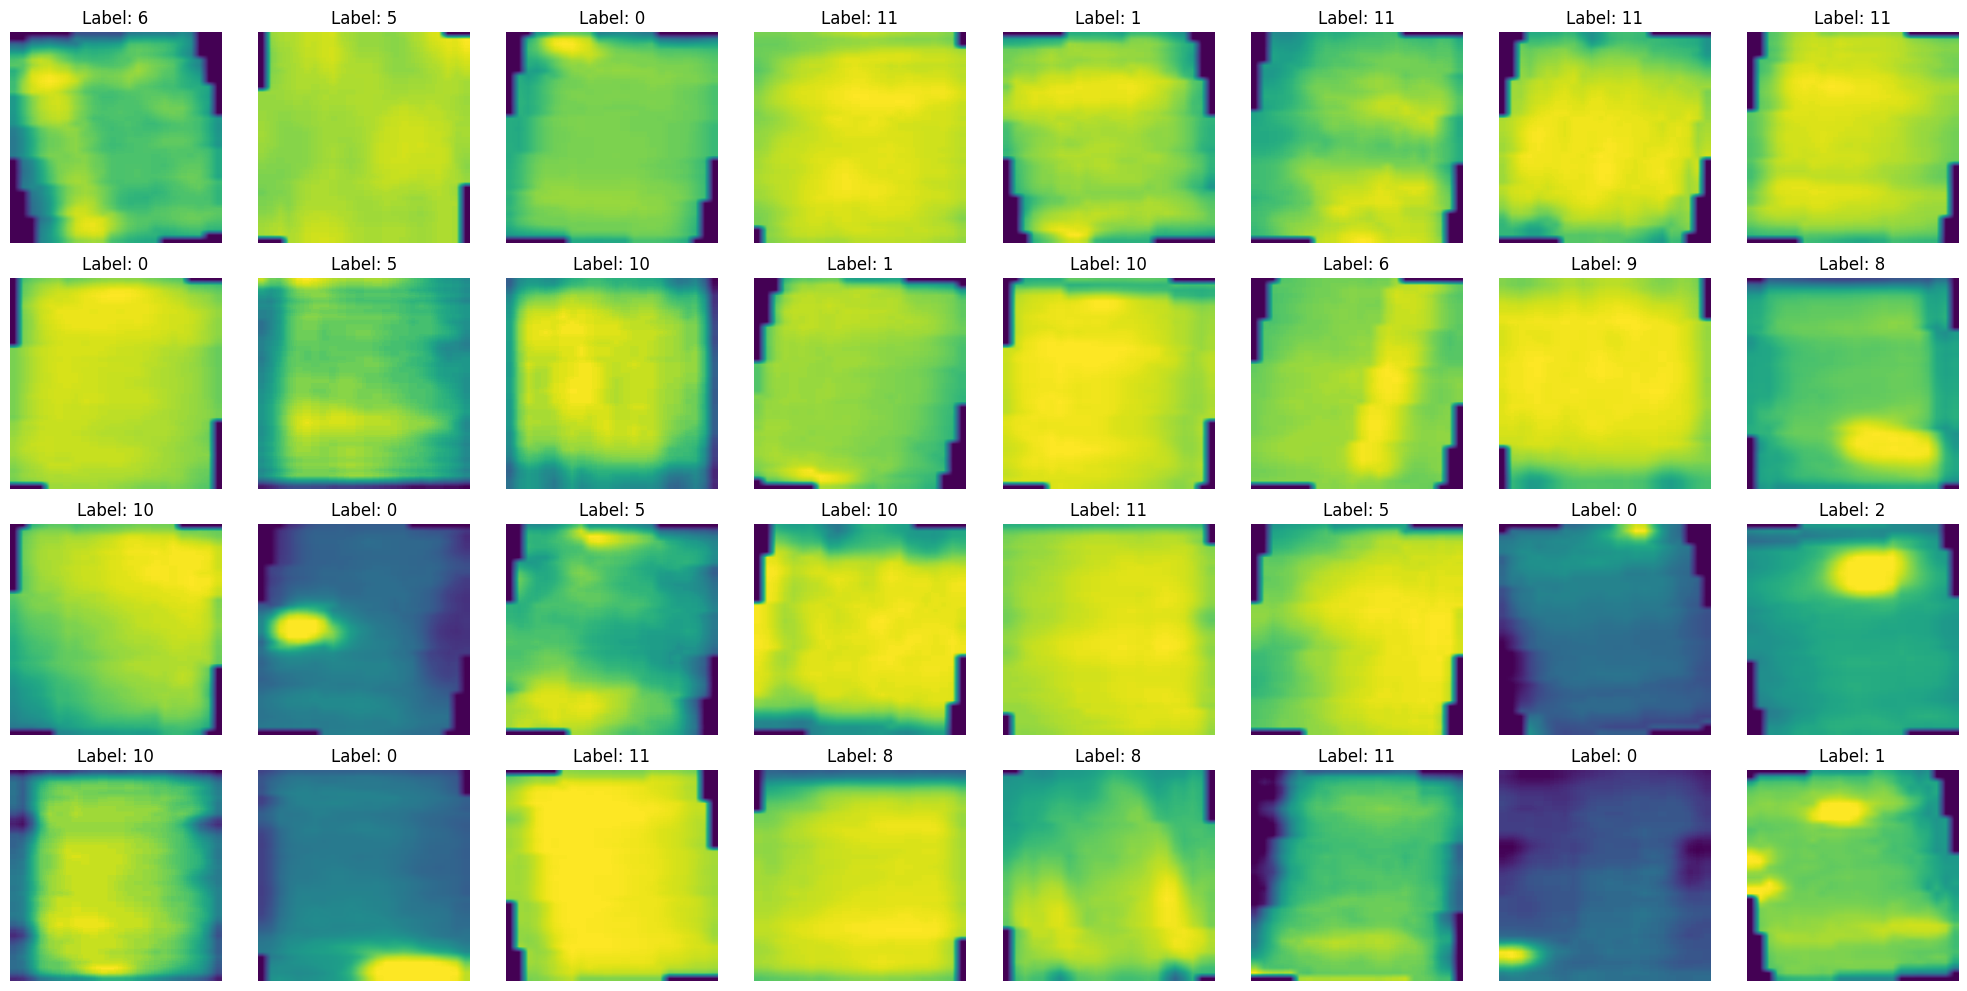

In [ ]:
# Show of a batch
images_3, labels_3 = next(iter(train_loader_3))
images_3 = images_3 * 0.5 + 0.5

fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
for i in range(len(images_3)):
    image = images_3[i]
    image_pil = transforms.ToPILImage()(image)
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels_3[i].item()}")
    axes[i].axis('off')

print("Image size", images_3[0].shape)
plt.tight_layout()
plt.show()

## EfficientNet Model

In [ ]:
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the first convolutional layer to accept grayscale images (1 channel)
# EfficientNet expects 3 channels, so we modify the first conv layer to accept 1 channel input
efficientnet_model._conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Modify the final classification layer for 12 classes
efficientnet_model._fc = nn.Linear(efficientnet_model._fc.in_features, 12)

# Send the model to the device (GPU or CPU)
efficientnet_model = efficientnet_model.to(device)

# Compute class weights based on class distribution
class_labels = train_data_3_balanced['anomaly_class'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights /= class_weights.sum()

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define loss function and optimizer
loss_fn_efficientnet = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer_efficientnet = optim.Adam(efficientnet_model.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler_efficientnet = ReduceLROnPlateau(optimizer_efficientnet, mode='min', factor=0.1, patience=5)


Loaded pretrained weights for efficientnet-b0


In [ ]:
def train(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    avg_loss = train_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy

In [ ]:
def test(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_loss = test_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy, y_true, y_pred

In [ ]:
# Training loop
import time

num_epochs = 20
best_accuracy = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_accuracy = train(efficientnet_model, train_loader_3, loss_fn_efficientnet, optimizer_efficientnet, device)
    test_loss, test_accuracy, _, _ = test(efficientnet_model, test_loader_3, loss_fn_efficientnet, device)

    # Step scheduler
    scheduler_efficientnet.step(test_loss)

    # Save the best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(efficientnet_model.state_dict(), "efficientnet_best_model_gray.pth")

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch time: {epoch_time:.2f} seconds\n")

Epoch 1/20
Train Loss: 1.5000, Train Accuracy: 0.4738
Test Loss: 1.0484, Test Accuracy: 0.6945
Epoch time: 355.06 seconds

Epoch 2/20
Train Loss: 1.0135, Train Accuracy: 0.6347
Test Loss: 0.8616, Test Accuracy: 0.7310
Epoch time: 352.75 seconds

Epoch 3/20
Train Loss: 0.8543, Train Accuracy: 0.6877
Test Loss: 0.7911, Test Accuracy: 0.7495
Epoch time: 352.99 seconds

Epoch 4/20
Train Loss: 0.7428, Train Accuracy: 0.7223
Test Loss: 0.7674, Test Accuracy: 0.7800
Epoch time: 353.06 seconds

Epoch 5/20
Train Loss: 0.6656, Train Accuracy: 0.7439
Test Loss: 0.7100, Test Accuracy: 0.7970
Epoch time: 352.84 seconds

Epoch 6/20
Train Loss: 0.5979, Train Accuracy: 0.7645
Test Loss: 0.6894, Test Accuracy: 0.8140
Epoch time: 352.93 seconds

Epoch 7/20
Train Loss: 0.5444, Train Accuracy: 0.7821
Test Loss: 0.7510, Test Accuracy: 0.8050
Epoch time: 352.66 seconds

Epoch 8/20
Train Loss: 0.4896, Train Accuracy: 0.7995
Test Loss: 0.7695, Test Accuracy: 0.8070
Epoch time: 352.11 seconds

Epoch 9/20
Train

In [ ]:
# Load the best model
efficientnet_model.load_state_dict(torch.load("efficientnet_best_model_gray.pth"))

# Test the model
test_loss_efficientnet, test_accuracy_efficientnet, y_true_efficientnet, y_pred_efficientnet = test(
    efficientnet_model, test_loader_3, loss_fn_efficientnet, device
)

print("EfficientNet Test Accuracy:", test_accuracy_efficientnet)

<ipython-input-26-82fdbb6f0333>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientnet_model.load_state_dict(torch.load("efficientnet_best_model_gray.pth"))


EfficientNet Test Accuracy: 0.8415



Confusion Matrix for EfficientNet:


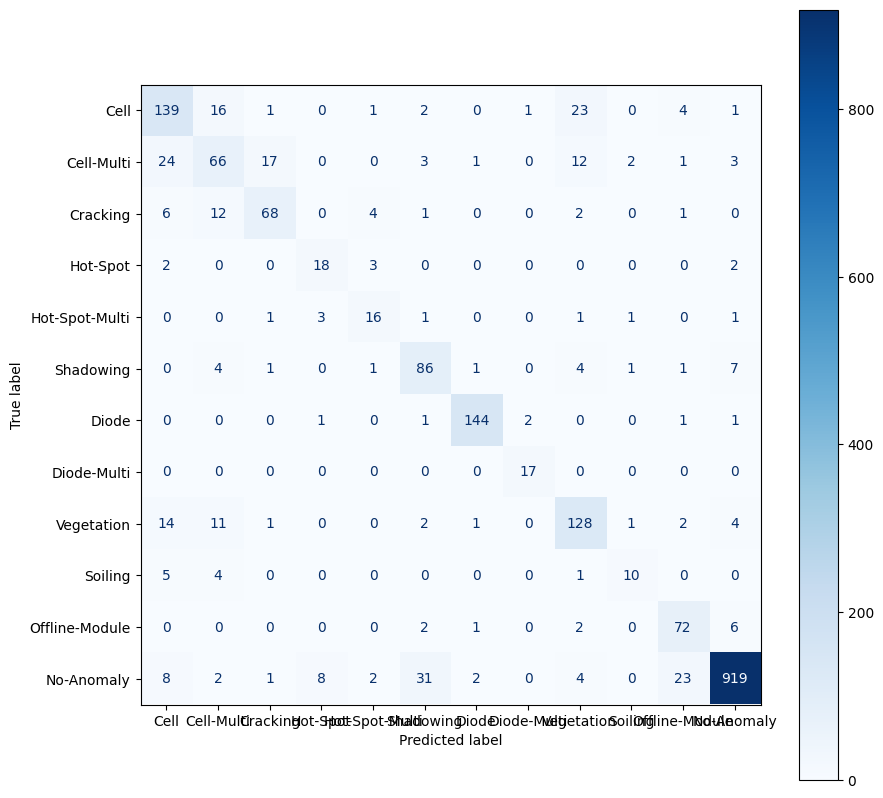

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(labels, pred_labels, class_names):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d', cmap='Blues', ax=ax)
    plt.show()

class_names_c = ['Cell', 'Cell-Multi', 'Cracking', 'Hot-Spot', 'Hot-Spot-Multi', 'Shadowing', 'Diode', 'Diode-Multi', 'Vegetation', 'Soiling', 'Offline-Module', 'No-Anomaly']

# Plot confusion matrix for EfficientNet
print("\nConfusion Matrix for EfficientNet:")
plot_confusion_matrix(y_true_efficientnet, y_pred_efficientnet, class_names_c)